In [1]:
import pandas as pd
import numpy as np
import math
import time
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score, rand_score, accuracy_score, precision_score, f1_score, adjusted_rand_score
from tribus import marker_expression
from minisom import MiniSom
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from tribus import run_tribus, heatmap_for_median_expression, marker_expression, umap_vis, z_score, cell_type_distribution
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Patch

# Define the functions used in this notebook

In [2]:
# def train_som(x, y, input_len, sigma, learning_rate, iterations): 
#     # a function to call minisom easily.

#     som = MiniSom(x=x, 
#                   y=y, 
#                   input_len = input_len, 
#                   sigma = sigma, 
#                   learning_rate = learning_rate, 
#                   neighborhood_function='gaussian')
#     som.random_weights_init(marker_data)
#     # training
#     start_time = time.time()
#     som.train_random(marker_data, iterations)
#     elapsed_time = time.time() - start_time
#     print(elapsed_time, " seconds")
#     return som

def cell_num_compare(true_label, pred_label): 
    # Plot barplots that show cell numbers in each type, compare with ground truth. 

    Tribus_stat = pd.DataFrame(np.array(np.unique(pred_label, return_counts=True)).T, columns=("Cell_type", "Tribus"))
    Truth_stat = pd.DataFrame(np.array(np.unique(true_label, return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
    Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
    Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
    Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

    Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)
    plt.show()


def get_subsets(sample_file, labels):
    # copied from Tribus. 

    cell_types = np.unique(labels)
    new_file = sample_file.copy()
    new_file.loc[:, 'labels'] = labels
    subsets = []
    normal_cell_types = []
    for cell_type in cell_types:
        if "undefined" in cell_type or "other" in cell_type:
            continue
        else:
            subsets.append(new_file.loc[new_file['labels'] == cell_type])
            normal_cell_types.append(cell_type)
    return subsets, normal_cell_types

def my_confusion_matrix(true_label, pred_label): 
    # Plot confusion matrix. 

    celltype_true = np.array(true_label).tolist()
    celltype_pred = np.array(pred_label).tolist()
    cm_labels = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def my_confusion_matrix_full(true_label, pred_label): 
    # Plot confusion matrix. 

    celltype_true = np.array(true_label).tolist()
    celltype_pred = np.array(pred_label).tolist()
    cm_labels = np.union1d(np.unique(celltype_pred), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def cluster_metrics_overall(celltype_true, celltype_pred): 
    # Calculate average accuracy metrics and visualization with barplot

    RI_avg = rand_score(celltype_true, celltype_pred) #between 0-1
    AS_avg = accuracy_score(celltype_true, celltype_pred)
    PS_avg = precision_score(celltype_true, celltype_pred, average='weighted')
    F1_avg = f1_score(celltype_true, celltype_pred, average="weighted")
    print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI_avg, AS_avg, PS_avg, F1_avg))
    df = pd.DataFrame([RI_avg, AS_avg, PS_avg, F1_avg], columns=['Value'], 
                    index = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"])

    colors = {"Rand Index": 'slateblue', "Accuracy Score": 'lightcoral', "Precision Score": 'firebrick', "F1 Score":'steelblue'}
    df.plot.bar(y='Value', width = 0.8, legend=False, 
                color=['slateblue', 'lightcoral', 'firebrick', 'steelblue'], rot=0, xticks=[])
    metric_labels = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"]
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
    plt.legend(handles, metric_labels)
    plt.show()

def cluster_metrics_percelltype(celltype_true, celltype_pred): 
    # accuracy metrics per cell type

    classes = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))
    stats_array = metrics.multilabel_confusion_matrix(celltype_true, celltype_pred, labels=classes)
    stats_df = pd.DataFrame()
    for i in range(len(stats_array)):
        stats_df = pd.concat([stats_df, pd.DataFrame(stats_array[i].flatten()).T])
    stats_df.columns = ["TN", "FP", "FN", "TP"]
    stats_df.index = [classes]
    stats_df["accuracy"] = (stats_df["TN"] + stats_df["TP"]) / (stats_df["TN"] + stats_df["TP"] + stats_df["FN"] + stats_df["FP"]) # in celesta paper they use this way to calculate Rand Index
    print(stats_df)
    report = metrics.classification_report(celltype_true, celltype_pred, labels=classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    # Support is the number of actual occurrences of the class in the specified dataset.
    rows = math.ceil(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))) / 4)
    fig, ax = plt.subplots(rows, 4, figsize=(15,7))

    for i in range(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true)))): 
        
        celltype = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))[i]
        df = report_df.loc[celltype]
        df["accuracy"] = stats_df.iloc[i,-1].tolist()
        df = df[["precision", "recall", "f1-score", "accuracy"]]
        
        colors = {"Precision Score": 'firebrick', "Recall Score": 'lightcoral', "F1 Score":'rosybrown', "accuracy": 'darksalmon'}
        df.plot.bar(y='Value', ax=ax[int(i / 4)][i % 4], width = 0.85, 
                    title="{}".format(celltype), legend=False, 
                    color=['firebrick', 'lightcoral', 'rosybrown', 'darksalmon'], rot=0, xticks=[])

    metric_labels = ["Precision Score", "Recall Score", "F1 Score", "accuracy"]
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
    plt.legend(handles, metric_labels)
    plt.show()

# Read in datasets

3 datasets was included in this analysis. 

- CODEX: published Co-detection by indexing (CODEX) imaging dataset collected from the healthy human colon (N = 110633 cells)
- CyTOF: published multiplexed ion beam imaging by time-of-flight (MIBI-TOF) dataset (N = 197678 cells) consisting of tissues from 41 triple-negative breast cancer patients.
- TMA: published tumor tissue microarray (TMA) dataset including a total of 112 cores from 44 high-grade serous ovarian cancers (HGSCs)

For Pre-processing: Keep it as simple as possible in order to see how minisom performs in complex datasets. 

- Remove outliers with 99.9 percentile. 
- No normalization was performed. 
- Currently, No cores in TMA were removed. 

In [3]:
data_type = "DCIS"
Q = 0.999
Logic = False # True means only use the markers include in logic table

In [4]:
if data_type == "CODEX": 

    # read in CODEX donor 004 cl dataset
    sample_data = pd.read_csv('C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
    print("Data dimension is {}".format(np.shape(sample_data)))

    #  perform always outlier truncation, set the maximum to the 99。9 percentile
    cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
        'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
        'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
        'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
        'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
        'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
        'Ki67', 'CD49a', 'CD163', 'CD161']

    df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\stellar_logic_gate_cl_minisom.xlsx")
    logic = pd.read_excel(df, df.sheet_names, index_col=0)
    markers = list(logic["Global"].index)

    celltype1 = "cell_type_A"
    celltype2 = "cell_type_upperlevel"

elif data_type == "HubMAP": 

    sample_data = pd.read_csv('C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\HubMAP\\input_data\\donor_004_CL.csv',low_memory=False)
    print("Data dimension is {}".format(np.shape(sample_data)))

    #  perform always outlier truncation, set the maximum to the 99。9 percentile
    cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
        'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
        'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
        'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
        'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
        'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
        'Ki67', 'CD49a', 'CD163', 'CD161']

    df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\HubMAP\\logic_gate_20230925.xlsx")
    logic = pd.read_excel(df, df.sheet_names, index_col=0)
    markers = list(logic["Global"].index)

    celltype1 = "Cell Type"
    celltype2 = "Cell subtype"

elif data_type == "TMA": 

    # read input files
    # no outlier filtering
    sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\TMA_works\\TMA_all_data_labeled.csv")
    print("Data dimension is {}".format(np.shape(sample_data)))

    #  perform always outlier truncation, set the maximum to the 99。9 percentile
    cols = ['CD11c', 'CD1c', 'CD4', 'CD3d', 'CD20', 'CD163',
        'CD8a', 'cCasp3', 'pSTAT1', 'Ki67', 'PDL1', 'IBA1', 'FOXP3', 'PD1',
        'Ecadherin', 'vimentin', 'CD31', 'P21', 'CK7', 'CD45',"Eccentricity"]
    
    celltype1 = "CellType"
    celltype2 = "merged_labels"

    df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\TMA_works\\cell_type_descriptions.xlsx")
    logic = pd.read_excel(df, df.sheet_names, index_col=0)
    markers = list(logic["Global"].index)
    
elif data_type == "CyTOF": 

    # read input files
    # no outlier filtering
    sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\input_data\\TNBC_Data_origin.csv")
    print("Data dimension is {}".format(np.shape(sample_data)))

    #  perform always outlier truncation, set the maximum to the 99。9 percentile
    cols = ['Vimentin', 'SMA','FoxP3', 'Lag3', 'CD4', 
            'CD16', 'CD56', 'PD1', 'CD31','PD-L1', 
            'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 
            'CD163','CD68', 'CD8', 'CD3', 'IDO', 
            'Keratin17', 'CD63','CD45RO', 'CD20', 'p53', 
            'Beta catenin', 'HLA-DR', 'CD11b', 'CD45',
            'Pan-Keratin', 'MPO','Keratin6']
    
    celltype1 = "DetailedGroup"
    celltype2 = "DetailedGroup"

    df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\logic_gate.xlsx")
    logic = pd.read_excel(df, df.sheet_names, index_col=0)
    markers = list(logic["Global"].index)

elif data_type == "DCIS": 

    # read input files
    # no outlier filtering
    sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\DCIS_MIBITOF\\input_data\\DCIS_data.csv")
    print("Data dimension is {}".format(np.shape(sample_data)))

    #  perform always outlier truncation, set the maximum to the 99。9 percentile
    cols = ["CD14", "P63", "CD4", "ECAD", "GLUT1", "MPO", "VIM", "CD3", 
        "SMA", "CD56", "PanKRT", "CD11c", "HER2", "CD68", "CK7", "CD8", 
        "PD1", "CD44", "HIF1a", "CD45", "FAP", "PDL1", "MMP9", "Ki67", 
        "CK5", "COX2", "CD20", "FOXP3", "IDO1", "CD36", "ECADKRT", "CD31", 
        "HH3", "ER", "AR", "pS6", "GZMB","Tryptase", "HLADRDPDQ"]
    
    celltype1 = "manual_gating_phenotype"
    celltype2 = "manual_gating_cellineage"

    df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\DCIS_MIBITOF\\logic_gate_20230910.xlsx")
    logic = pd.read_excel(df, df.sheet_names, index_col=0)
    markers = list(logic["Global"].index)

sample_data[cols] = z_score(np.log(sample_data[cols]+1))
Q = sample_data[cols].quantile(Q)
sample_data = sample_data[~((sample_data[cols] > Q)).any(axis=1)]
print("Removing the outliers. Curent data dimension is {}".format(np.shape(sample_data)))
sample_data[cols].describe()

labels_true_1 = sample_data[celltype1]
print("Cell types in detailed is {}".format(np.unique(labels_true_1)))
labels_true_2 = sample_data[celltype2]
print("Cell types merged (optional) is {}".format(np.unique(labels_true_2)))

grid_size = int(np.sqrt(np.sqrt(len(sample_data)) * 5))
print("Current dataset is {}".format(data_type))
print("The grid size for miniSOM is {}".format(grid_size))

if logic == "FALSE":    
    marker_data = np.arcsinh(sample_data[cols]).to_numpy()
else: 
    marker_data = np.arcsinh(sample_data[markers]).to_numpy()


Data dimension is (69672, 136)
Removing the outliers. Curent data dimension is (67434, 136)
Cell types in detailed is ['APC' 'BCELL' 'CAF' 'CD4T' 'CD8T' 'DC' 'ENDO' 'FIBRO_VIMonly'
 'IMMUNEOTHER' 'MACS' 'MAST' 'MONO' 'MONODC' 'MYOEP' 'MYOFIBRO' 'NEUT'
 'NORMFIBRO' 'OTHER' 'TCELL' 'TUMOR_CK5' 'TUMOR_ECADCK' 'TUMOR_EMT'
 'TUMOR_LUMINAL']
Cell types merged (optional) is ['ENDO' 'FIBROBLAST' 'IMMUNE' 'MYOEP' 'OTHER' 'TUMOR']
Current dataset is DCIS
The grid size for miniSOM is 36


In [ ]:
marker_expression(sample_data[cols], markers=None, save=False, fname=None, dpi='figure', log=False)

# Run miniSOM

In [6]:
# Initialization and training
# grid_size=100
som_shape = (grid_size, grid_size)
som = MiniSom(som_shape[0], som_shape[1], marker_data.shape[1], sigma=1, learning_rate=2,
              neighborhood_function='gaussian', random_seed=42)

som.train_batch(marker_data, 1000, verbose=True)
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in marker_data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
print("Number of clusters generated: {}".format(len(np.unique(cluster_index))))
# A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
print("Homogeneity score calculated with detailed cell types: {}". format(homogeneity_score(labels_true_1, cluster_index)))
print("Homogeneity score calculated with merged cell types: {}". format(homogeneity_score(labels_true_2, cluster_index)))
print("Completeness score calculated with detailed cell types: {}". format(completeness_score(labels_true_1, cluster_index)))
print("Completeness score calculated with merged cell types: {}". format(completeness_score(labels_true_2, cluster_index)))

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.7128985835490013
Number of clusters generated: 729
Homogeneity score calculated with detailed cell types: 0.6814737506804731
Homogeneity score calculated with merged cell types: 0.7862395554274135
Completeness score calculated with detailed cell types: 0.31926848289285675
Completeness score calculated with merged cell types: 0.21226309402950388


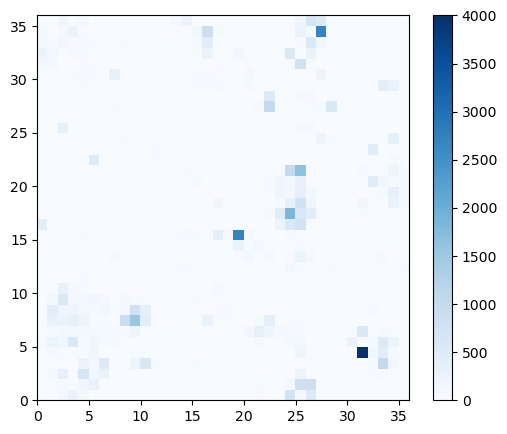

In [7]:
plt.figure(figsize=(6,5))
frequencies = som.activation_response(marker_data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

# Hyperparameter tuning

In [47]:
# set hyperparameters
rows_data = marker_data.shape[0]
x = int(np.sqrt(5 * np.sqrt(rows_data)))
print("x is {}".format(x))
y = x
input_len = marker_data.shape[1]
sigma = 0.003
learning_rate = 5
iterations = 100

space = {
    'sig': hp.uniform("sig", 0.001, 5), 
    'learning_rate': hp.uniform("learning_rate", 0.001, 5),
}

def som_fn(space): 
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=x, 
                  y=x, 
                  input_len=input_len,
                  sigma=sig,
                  learning_rate=learning_rate
                  ).quantization_error(marker_data)
    print("Current quantization error is {}".format(val))
    return{'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn = som_fn, 
            space=space, 
            algo = tpe.suggest, 
            max_evals=15, 
            trials=trials)

print('best: {}'.format(best))

# for i, trial in enumerate(trials.trials[:2]): 
#     print(i, trials)

x is 36
  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]

Current quantization error is 1.6361612809290391      
Current quantization error is 1.6243440199547714                                
Current quantization error is 1.6311835000429926                                
Current quantization error is 1.6229976056946644                                
Current quantization error is 1.6323126046437242                                
Current quantization error is 1.6240739657094614                                
Current quantization error is 1.614497664233297                                 
Current quantization error is 1.6342276631439017                                
Current quantization error is 1.6393754863230598                               
Current quantization error is 1.6161184157051935                               
Current quantization error is 1.629089776524658                                 
Current quantization error is 1.622459821687258                                 
Current quantization error is 1.6370665488149605        

In [48]:
sigma = best['sig']
learning_rate = best['learning_rate']
print("Current grid size x is {}, grid size y is {}, sigma is {}, learning rate is {}.".format(x, y, sigma, learning_rate))

Current grid size x is 36, grid size y is 36, sigma is 1.3603274234289846, learning rate is 0.9283977367482288.


In [49]:
som = MiniSom(x, y, input_len, sigma=sigma, learning_rate=learning_rate,
              neighborhood_function='gaussian')

som.train_batch(marker_data, 500, verbose=True)

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in marker_data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
som_shape = (grid_size, grid_size)
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

print("Number of clusters generated: {}".format(len(np.unique(cluster_index))))

# A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
print("Homogeneity score calculated with detailed cell types: {}". format(homogeneity_score(labels_true_1, cluster_index)))
print("Homogeneity score calculated with merged cell types: {}". format(homogeneity_score(labels_true_2, cluster_index)))
print("Completeness score calculated with detailed cell types: {}". format(completeness_score(labels_true_1, cluster_index)))
print("Completeness score calculated with merged cell types: {}". format(completeness_score(labels_true_2, cluster_index)))


 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.9468263771528211
Number of clusters generated: 712
Homogeneity score calculated with detailed cell types: 0.6375187987539395
Homogeneity score calculated with merged cell types: 0.7374364618907537
Completeness score calculated with detailed cell types: 0.32929022727162044
Completeness score calculated with merged cell types: 0.21949424518705682


# Feature selection

In [222]:
def som_feature_selection(W, labels, target_index = 0, a = 0.04):
    """ Performs feature selection based on a self organised map trained with the desired variables

    INPUTS: W = numpy array, the weights of the map (X*Y*N) where X = map's rows, Y = map's columns, N = number of variables
            labels = list, holds the names of the variables in same order as in W
            target_index = int, the position of the target variable in W and labels
            a = float, an arbitary parameter in which the selection depends, values between 0.03 and 0.06 work well

    OUTPUTS: selected_labels = list of strings, holds the names of the selected features in order of selection
             target_name = string, the name of the target variable so that user is sure he gave the correct input
    """


    W_2d = np.reshape(W, (W.shape[0]*W.shape[1], W.shape[2])) #reshapes W into MxN assuming M neurons and N features
    target_name = labels[target_index]


    Rand_feat = np.random.uniform(low=0, high=1, size=(W_2d.shape[0], W_2d.shape[1] - 1)) # create N -1 random features
    W_with_rand = np.concatenate((W_2d,Rand_feat), axis=1) # add them to the N regular ones
    W_normed = (W_with_rand - W_with_rand.min(0)) / W_with_rand.ptp(0) # normalize each feature between 0 and 1

    Target_feat = W_normed[:,target_index] # column of target feature

    # Two conditions to check against a
    Check_matrix1 = abs(np.vstack(Target_feat) - W_normed)
    Check_matrix2 = abs(np.vstack(Target_feat) + W_normed - 1)
    S = np.logical_or(Check_matrix1 <= a, Check_matrix2 <= a).astype(int) # applie "or" element-wise in two matrices

    S[:,target_index] = 0 #ignore the target feature so that it is not picked

    selected_labels = []
    while True:

        S2 = np.sum(S, axis=0) # add all rows for each column (feature)

        if not np.any(S2 > 0): # if all features add to 0 kill
            break

        selected_feature_index = np.argmax(S2) # feature with the highest sum gets selected first

        if selected_feature_index > (S.shape[1] - (Rand_feat.shape[1] + 1)): # if random feature is selected kill
            break


        selected_labels.append(labels[selected_feature_index])

        # delete all rows where selected feature evaluates to 1, thus avoid selecting complementary features
        rows_to_delete = np.where(S[:,selected_feature_index] == 1)
        S[rows_to_delete, :] = 0

#     selected_labels = [label for i, label in enumerate(labels) if i in feature_indeces]
    return selected_labels, target_name

In [223]:
size = som_shape[0]
som = MiniSom(som_shape[0], som_shape[1], marker_data.shape[1],
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(marker_data)
som.train_random(marker_data, 1000, verbose=True)
W = som.get_weights()

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.8152134951218467


IndexError: index 11 is out of bounds for axis 2 with size 11

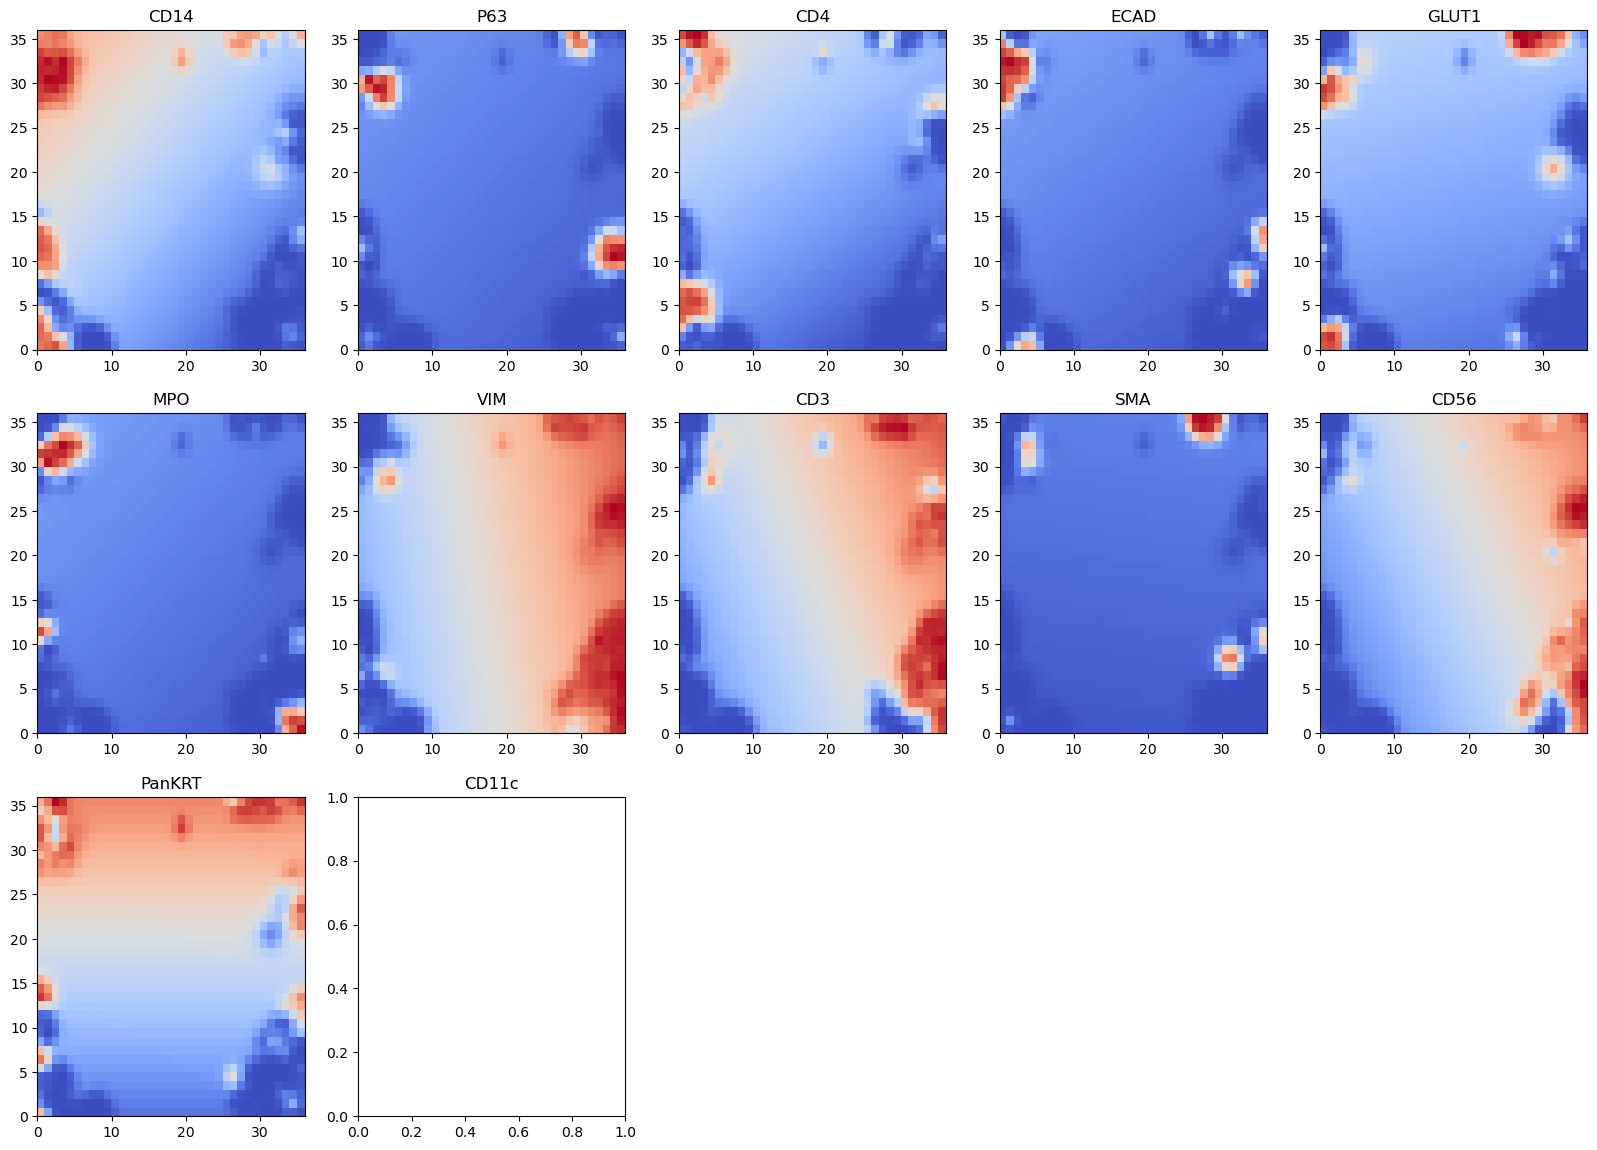

In [224]:
plt.figure(figsize=(2.5*round(len(cols)/5), len(cols)))
for i, f in enumerate(cols):
    plt.subplot(round(len(cols)/5), 5, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [40]:
selected_features, target_name = som_feature_selection(W, cols, 0, 0.04)
print("Target variable: {}\nSelected features {}".format(target_name, selected_features))

Target variable: MUC2
Selected features ['ITLN1', 'CD31', 'CD44', 'Vimentin', 'HLADR', 'CD123', 'CD127']


# Check the initial clusters

In this part I'm aiming to check whether miniSOM can successfully clustered same cell types together. 
1. Calculate the counts of cells in each cell type per cluster.
2. Extract the cell type that dominant the cluster (the one that has largest counts)
3. The cluster will be annotated by the corresponding cell type. 
4. Visualize the result.

In [8]:
# getting cell types

d = {'real': np.array(labels_true_2), 'pred': cluster_index}
df = pd.DataFrame(data = d)

pd.options.display.max_rows = 100
df_count = df.groupby(["pred", "real"]).size().reset_index(name='counts')
df_assign = df_count.groupby('pred').apply(lambda x: x.real[x.counts.idxmax()])
dict_replace = df_assign.to_dict()

# Define a function that takes an element and returns its replacement
def replace(element):
    return dict_replace.get(element, element)
# Vectorize the function
vfunc = np.vectorize(replace)
# Apply the function to our array
labels_df = vfunc(cluster_index)

labels_df = pd.DataFrame(labels_df)
labels_df.columns = ["Global"]

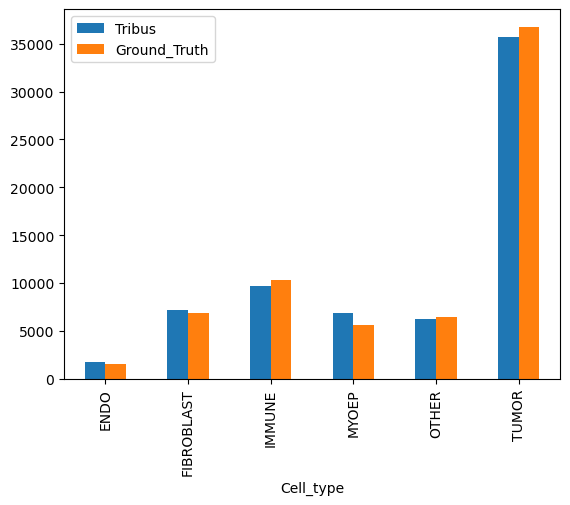

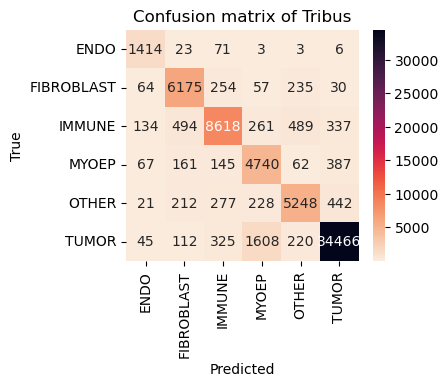

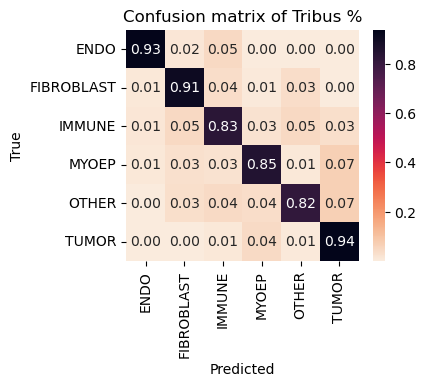

Rand score = 0.9175965553830416, Accuracy score = 0.8995610522881632, Precision score = 0.905117353651717, F1 score = 0.9011854427592185


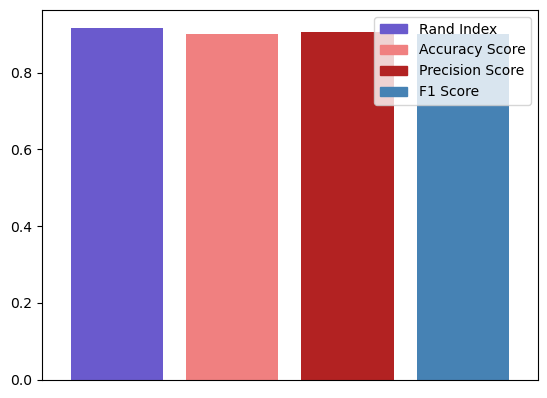

In [9]:
# visualize
cell_num_compare(labels_true_2, labels_df["Global"])
my_confusion_matrix(labels_true_2, labels_df["Global"])
cluster_metrics_overall(labels_true_2, labels_df["Global"])

# Origin Scoring functions

In this part I extract the scoring function in Tribus and use it to annotate minisom result. 

## Calculate scores

In [10]:
def score_marker_pos(x):
    """
    get the largest value for a marker, subtract from it all the values --> take the squared
    large values will get small values, small values get larger values
    """
    res = [(np.percentile(x, MAX_PERCENTILE) - i) ** 2 for i in x]
    return res


def score_marker_neg(x):
    """
    substrach the minimum from each value --> take the squared
    large values remain large, small values became smaller
    """
    res = [(i - np.min(x)) ** 2 for i in x]
    return res


def normalize_scores(x):
    """
    normalize the values between 0-1
    change the direction of scoring, smaller ones becomes the larger ones and vica versa (inverting)
    """
    if np.max(x) - np.min(x) == 0:
        print(x)

    res = 1 - ((x - np.min(x)) / (np.max(x) - np.min(x)))
    return res

In [11]:
def score_nodes(data_to_score, logic, level):
    """
    scoring function for the clusters, which cluster belong to which cell-type
    data_to_score: dataframe
    logic: dictionary of dataframes
    level: string
    returns: dataframe
    """
    level_logic_df = logic[level] # 2. extract logic table
    scores_matrix = np.zeros((data_to_score.shape[0], logic[level].shape[1]))
    for idx, cell_type in enumerate(logic[level].columns.values): # get 1 celltype1 2 celltype2...

        print(idx, cell_type)

        list_negative = list(
            level_logic_df.loc[level_logic_df[cell_type] == -1].index)  # get markers with negative scores
        list_positive = list(
            level_logic_df.loc[level_logic_df[cell_type] == 1].index)  # get markers with positive scores

        if list_positive == 0:
            continue

        gating_positive = data_to_score[list_positive].to_numpy()  # rows: clusters, columns: positive markers
        marker_scores_positive = np.apply_along_axis(score_marker_pos, 0, gating_positive) # 3. Transform the expression of positive markers

        if len(list_negative) != 0:
            gating_negative = data_to_score[list_negative].to_numpy()
            marker_scores_negative = np.apply_along_axis(score_marker_neg, 0, gating_negative) # 4. Transform the expression of negative markers

            marker_scores = np.column_stack((marker_scores_positive, marker_scores_negative)) # Merge pos and neg result. num of Rows: cluster, num of cols: pos + neg
        else:
            marker_scores = marker_scores_positive

        normalized_marker_scores = np.apply_along_axis(normalize_scores, 0, marker_scores) # normalize the scores

        scores_matrix[:, idx] = np.mean(normalized_marker_scores, 1) # put the mean of the marker values of a celltype into a matrix (indexed by the celltypes)
        
    scores_pd = pd.DataFrame(scores_matrix, columns=logic[level].columns.values, index=data_to_score.index)
    return marker_scores_positive, marker_scores_negative, marker_scores, normalized_marker_scores, scores_pd

def get_cell_type(x, level, undefined_threshold, other_threshold):
    '''
    assigning cell type based on the score, write "other" if highest score is too low, write "undifined" if the two highest score are too close to eachother
    '''
    sorted_ = np.sort(x)
    highest = sorted_[-1]
    second_highest = sorted_[-2]
    if highest < other_threshold:
        return f'other_{level}'
    if highest-second_highest < undefined_threshold:
        return f'undefined_{level}'
    return x.idxmax()

def get_probabilities(x):
    '''
    assigning the highest probability to each cell
    '''
    return np.max(x)

In [50]:
level = "Global"
labeled = sample_data[logic[level].index.values].copy()
labeled['label'] = cluster_index
data_to_score = labeled.groupby('label').median() # 1. Calculate median marker expression per cluster. 
data_to_score

,VIM,CD31,CD45,FAP,SMA,CD36,PanKRT,ECAD,P63,CK7,CD44
label,,,,,,,,,,,
1,0.947219,-0.227353,-0.518809,-0.287044,-0.498846,-0.275182,0.334264,-0.086831,-0.199822,0.118486,-0.968726
4,-0.760760,-0.227353,-0.518809,-0.287044,-0.425754,-0.275182,0.634075,0.444522,-0.199822,0.698124,-0.380234
5,-0.760760,-0.227353,-0.518809,-0.287044,-0.498846,-0.275182,0.425252,0.535755,-0.199822,0.538776,-0.968726
6,-0.760760,-0.227353,-0.518809,-0.287044,-0.498846,-0.275182,-0.123794,0.889572,-0.199822,0.685406,-0.172115
7,-0.608771,-0.227353,-0.518809,-0.287044,-0.498846,-0.275182,0.413464,-0.255961,-0.199822,0.730188,-0.107622
...,...,...,...,...,...,...,...,...,...,...,...
1282,1.356668,-0.227353,1.398205,2.346334,-0.498846,-0.275182,0.526414,-1.103453,-0.199822,1.159221,1.108860
1287,-0.130643,-0.227353,-0.518809,-0.287044,-0.498846,0.382051,-0.911118,0.577791,-0.199822,-0.850985,0.364047
1291,1.183684,-0.227353,0.925811,0.836112,-0.498846,-0.275182,0.598408,1.113997,-0.199822,-0.850985,1.118864


In [51]:
def normalize_row(row):
    return (row - np.mean(row)) / np.std(row)
data_to_score = data_to_score.apply(normalize_row, axis=0)
data_to_score = data_to_score.apply(normalize_row, axis=1)
data_to_score

,VIM,CD31,CD45,FAP,SMA,CD36,PanKRT,ECAD,P63,CK7,CD44
label,,,,,,,,,,,
1,1.103418,-0.414717,-0.642925,-0.415430,-0.617375,-0.440882,0.055502,-0.442943,-0.376793,-0.011175,-1.097583
4,-0.845968,-0.414717,-0.642925,-0.415430,-0.542600,-0.440882,0.455627,0.196932,-0.376793,0.642767,-0.430234
5,-0.845968,-0.414717,-0.642925,-0.415430,-0.617375,-0.440882,0.176933,0.306798,-0.376793,0.462992,-1.097583
6,-0.845968,-0.414717,-0.642925,-0.415430,-0.617375,-0.440882,-0.555821,0.732877,-0.376793,0.628419,-0.194227
7,-0.672497,-0.414717,-0.642925,-0.415430,-0.617375,-0.440882,0.161202,-0.646615,-0.376793,0.678941,-0.121092
...,...,...,...,...,...,...,...,...,...,...,...
1282,1.570739,-0.414717,1.627133,2.015994,-0.617375,-0.440882,0.311943,-1.667195,-0.376793,1.162971,1.258396
1287,-0.126790,-0.414717,-0.642925,-0.415430,-0.617375,0.133420,-1.606578,0.357419,-0.376793,-1.104922,0.413780
1291,1.373305,-0.414717,1.067742,0.621592,-0.617375,-0.440882,0.408026,1.003137,-0.376793,-1.104922,1.269741


In [52]:
MAX_PERCENTILE = 99.9
marker_scores_positive, marker_scores_negative, marker_scores, normalized_marker_scores, scores_pd = score_nodes(data_to_score, logic, "Global")

0 ENDO
1 FIBROBLAST
2 IMMUNE
3 MYOEP
4 TUMOR


In [43]:
pd.DataFrame(marker_scores_positive)

,0,1
0,0.717097,2.392144
1,0.299215,1.030839
2,0.571276,0.853904
3,1.702697,0.325187
4,0.589234,2.943919
...,...,...
724,0.428588,6.570392
725,4.377292,0.777983
726,0.339507,0.119597
727,0.233928,0.068192


In [16]:
pd.DataFrame(marker_scores_negative)

,0,1,2
0,0.953435,1.540528,1.699603
1,0.580154,1.442907,1.390845
2,0.997102,1.614163,1.962443
3,0.779378,1.327856,1.586778
4,0.646816,1.178013,1.695360
...,...,...,...
724,7.306957,0.878202,0.576743
725,1.440726,2.135363,2.215458
726,6.765646,0.624944,0.475757
727,9.626259,0.665443,6.184089


In [17]:
pd.DataFrame(marker_scores)

,0,1,2,3,4
0,2.939406,7.595722,0.953435,1.540528,1.699603
1,0.644941,2.194510,0.580154,1.442907,1.390845
2,1.519253,1.113435,0.997102,1.614163,1.962443
3,8.656556,0.144885,0.779378,1.327856,1.586778
4,1.374517,10.981586,0.646816,1.178013,1.695360
...,...,...,...,...,...
724,6.070299,18.625091,7.306957,0.878202,0.576743
725,20.039947,1.376168,1.440726,2.135363,2.215458
726,4.830014,2.513569,6.765646,0.624944,0.475757
727,5.849606,4.162631,9.626259,0.665443,6.184089


<Axes: xlabel='1', ylabel='2'>

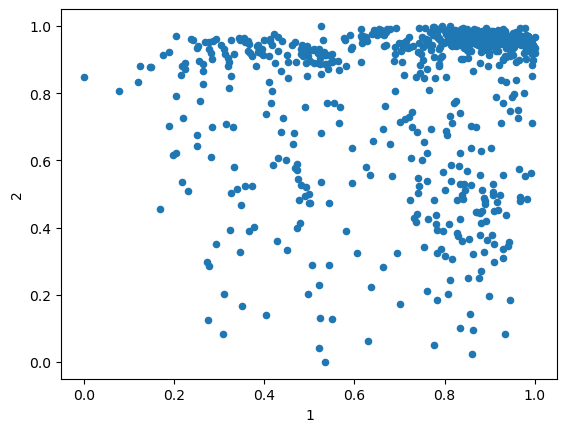

In [18]:
pd.DataFrame(normalized_marker_scores).plot.scatter(1,2)

In [19]:
scores_pd

,ENDO,FIBROBLAST,IMMUNE,MYOEP,TUMOR
label,,,,,
1,0.806177,0.832024,0.742518,0.650284,0.874601
4,0.521355,0.489686,0.449560,0.526398,0.943957
5,0.571813,0.512162,0.488011,0.565532,0.932929
6,0.547843,0.549870,0.510031,0.536535,0.887979
7,0.586141,0.651897,0.585712,0.472439,0.868556
...,...,...,...,...,...
1282,0.578148,0.797635,0.881069,0.484199,0.712214
1287,0.729486,0.766953,0.705832,0.747549,0.759999
1291,0.593450,0.692787,0.790079,0.558671,0.856202


In [53]:
# assign highest scored label
undefined_threshold=0.01
other_threshold=0.4

scores_labels = pd.DataFrame()
scores_labels['cell_label'] = scores_pd.apply(lambda x: get_cell_type(x, level, undefined_threshold, other_threshold), axis=1)
scores_labels['probability'] = scores_pd.apply(get_probabilities, axis=1)
labels_list = scores_labels.loc[labeled['label']].cell_label # according to the cluster labels, assign the most probable cell-type to each cell
prob_list = scores_labels.loc[labeled['label']].probability
labels_df = pd.DataFrame(labels_list)
labels_df = labels_df.set_index(labeled.index)
prob_df = pd.DataFrame(prob_list)
prob_df = prob_df.set_index(labeled.index)
labels_df = labels_df.rename(columns={'cell_label': level})
prob_df = prob_df.rename(columns={'probability': level})

In [21]:
scores_labels['cell_label']

label
1                  TUMOR
4                  TUMOR
5                  TUMOR
6                  TUMOR
7                  TUMOR
              ...       
1282              IMMUNE
1287    undefined_Global
1291               TUMOR
1294              IMMUNE
1295    undefined_Global
Name: cell_label, Length: 729, dtype: object

In [22]:
scores_labels['probability']

label
1       0.874601
4       0.943957
5       0.932929
6       0.887979
7       0.868556
          ...   
1282    0.881069
1287    0.766953
1291    0.856202
1294    0.828093
1295    0.727420
Name: probability, Length: 729, dtype: float64

In [23]:
labels_list

label
931         TUMOR
65          TUMOR
750         TUMOR
112         TUMOR
103         TUMOR
          ...    
819    FIBROBLAST
202        IMMUNE
699        IMMUNE
901        IMMUNE
699        IMMUNE
Name: cell_label, Length: 67434, dtype: object

In [24]:
scores_labels

,cell_label,probability
label,,
1,TUMOR,0.874601
4,TUMOR,0.943957
5,TUMOR,0.932929
6,TUMOR,0.887979
7,TUMOR,0.868556
...,...,...
1282,IMMUNE,0.881069
1287,undefined_Global,0.766953
1291,TUMOR,0.856202


## Visualize the results

Text(0.5, 1.0, 'Distributions of node probability')

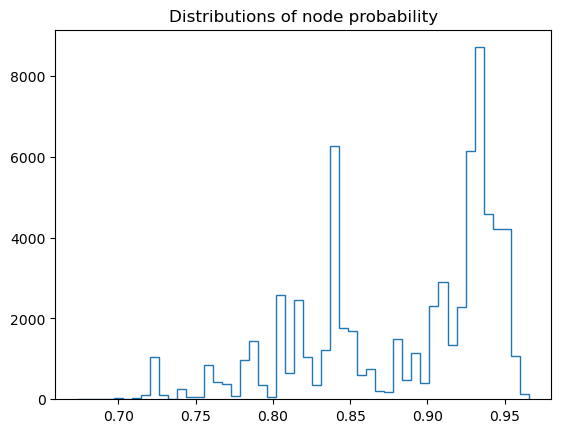

In [25]:
hist, edges = np.histogram(prob_df, bins=50)
plt.stairs(hist, edges)
plt.title("Distributions of node probability")

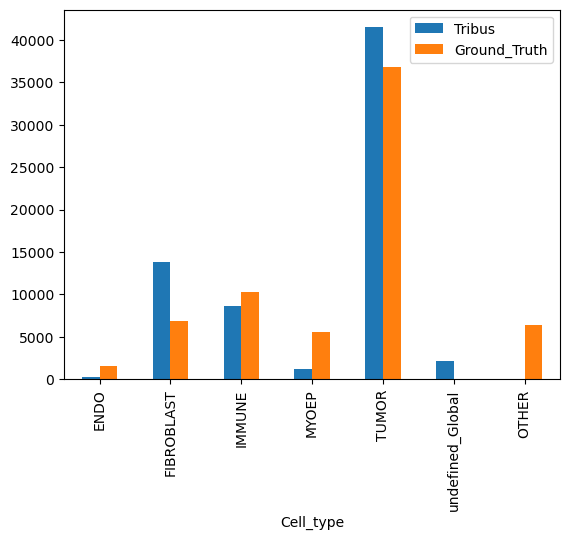

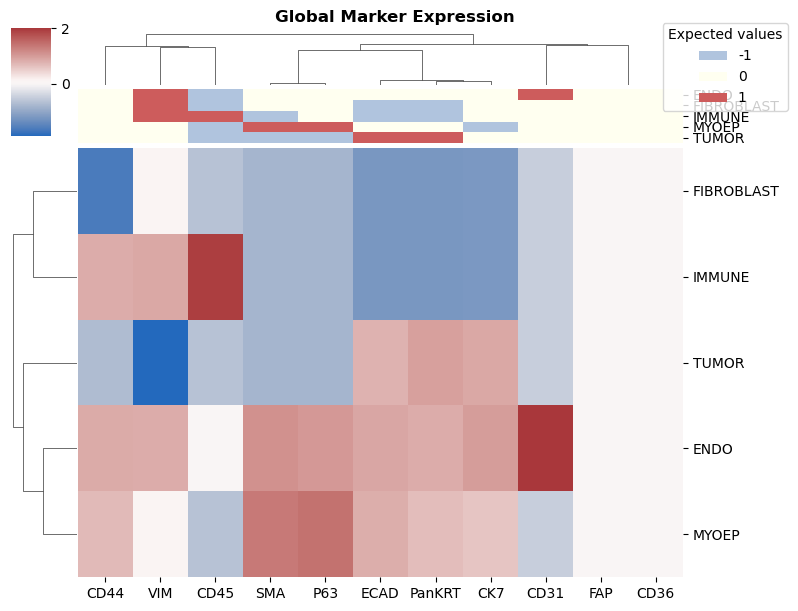

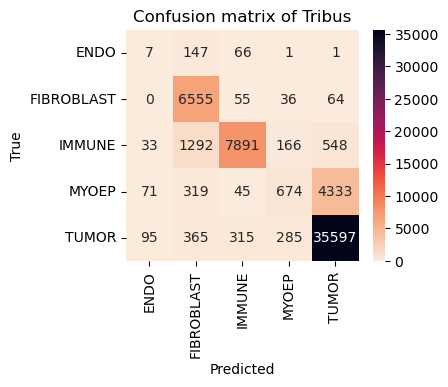

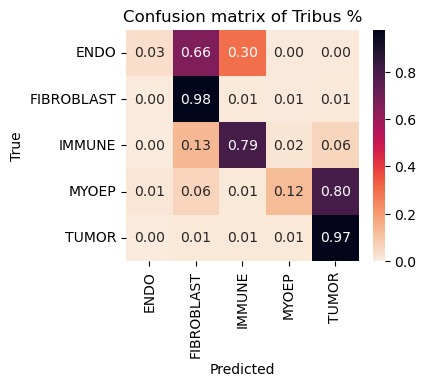

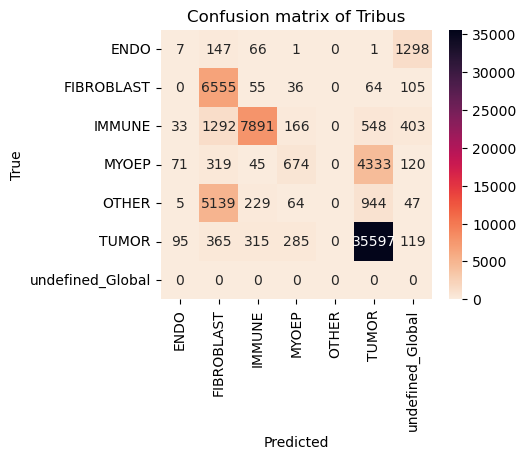

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_16316\4222702673.py:99: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


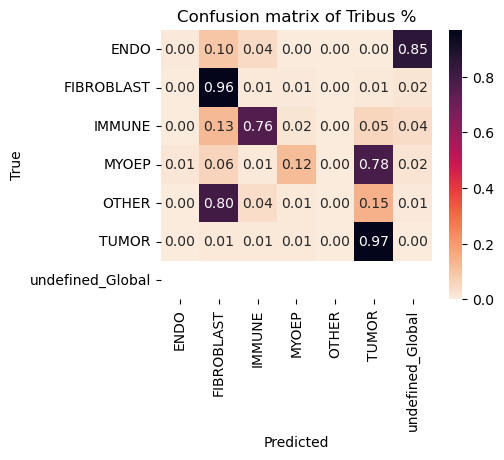

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.8404334527133072, Accuracy score = 0.7522021532164783, Precision score = 0.7025560482681508, F1 score = 0.704604668263382


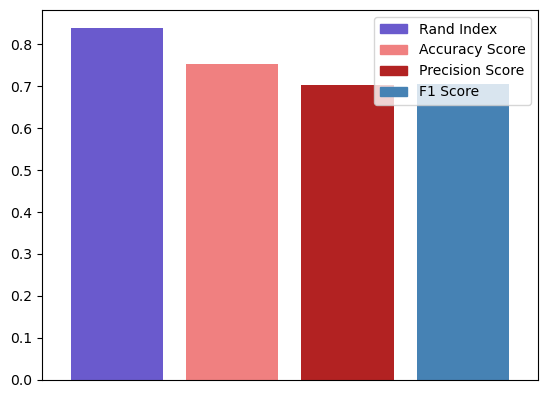

In [54]:
cell_num_compare(labels_true_2, labels_df["Global"])

heatmap_for_median_expression(sample_data, labels_df, logic, level="Global", save=False, fname=None,
                                dpi='figure', transform=z_score, title="{} Marker Expression".format(level),
                                c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                cmap_='vlag', dendrogram_ratio_=0.1)

my_confusion_matrix(labels_true_2, labels_df["Global"])
my_confusion_matrix_full(labels_true_2, labels_df["Global"])
cluster_metrics_overall(labels_true_2, labels_df["Global"])

# Write GMM functions

In [27]:
from sklearn.mixture import GaussianMixture as GMM

def appr_fun(x, xroot, slope):
    ## heuristic for axxproimating the decision boundary
    y = np.exp( (x - xroot) * slope)
    y = y / (1.0 + y)
    return np.squeeze(y)

def compute_paras(mk_model, mk):
    ## compute the critical point of the decision bounary
    ## critical point is defined by P(theta = 1|x) = P(theta = 0|x) 
    ## given a 1-D two-mixture model
    ##
    ## inputs:
    ## mk_model: precomputed 2-gassian mixture model for all markers
    ## mk: one selected marker
    ##
    ## outputs:
    ## xroot: location of the critical point
    ## slope: slope of the decision boundary at the critical point
    
    mus, sigmas, ws = mk_model[mk]
    a = (-0.5 / sigmas[0] + 0.5 /sigmas[1])
    b = mus[0] / sigmas[0] - mus[1] / sigmas[1]
    c = 0.5 * (-mus[0] **2 / sigmas[0] + mus[1] ** 2 / sigmas[1]) + np.log(ws[0] / ws[1]) + 0.5 * np.log(sigmas[1] / sigmas[0])
    xroot = (-b - np.sqrt(b ** 2 - 4.0 * a * c) ) / (2.0 * a)
    slope = 0.5 * (xroot - mus[0]) / sigmas[0] - 0.5 * (xroot - mus[1]) / sigmas[1]
    return xroot, slope

def score_fun(x, mk_model, mk):
    ## compute the score function
    ## the score should roughly proportional to P(theta = + | x)

    xroot, slope = compute_paras(mk_model, mk)
    return appr_fun(x, xroot, slope)

def get_score_mat_main(X, table, mk_model):
    ## compute the cluster x annotation score matrix
    ## X: sample x feature data matrix
    ## table: a list of (ind, sign)
    score = np.zeros((X.shape[0], len(table.axes[1])))
    for i, ct in enumerate(table.columns):
        #score_tmp = np.zeros(X.shape[0])
        #count = 0.0
        score_tmp = np.ones(X.shape[0])
        count = 1.0
        for j, mk in enumerate(table.index):
            if table.loc[mk, ct] > 0:
                score_tmp =  np.min([score_tmp, score_fun(X[:, j], mk_model, mk)], axis = 0)
                #score_tmp +=  score_fun(X[:, j], mk_model, mk)
                #count += 1.0
            elif  table.loc[mk, ct] < 0:
                score_tmp =  np.min([score_tmp, 1.0 - score_fun(X[:, j], mk_model, mk)], axis = 0)
                #score_tmp +=  1.0 - score_fun(X[:, j], mk_model, mk)
                #count += 1.0
        score[:, i]= score_tmp / count
    return score

def compute_marker_model(df, table, thres):
    ## compute 2-gaussian mixture model for each marker
    ## output mean, variance, and weight for each marker
    mk_model = {}
    for mk in table.axes[0]:
        gmm = GMM(n_components=2, n_init=50, init_params="random_from_data")
        tmp = df[mk].to_numpy()
        gmm.fit(tmp[tmp > thres, np.newaxis])
        index = np.argsort(gmm.means_, axis = 0)    
        mk_model[mk] = (gmm.means_[index], gmm.covariances_[index], gmm.weights_[index])
        
    return mk_model

In [34]:
level = "Global"
labeled = sample_data[logic[level].index.values].copy()
labeled['label'] = cluster_index
data_to_score = labeled.groupby('label').median() # 1. Calculate median marker expression per cluster. 
data_to_score

,VIM,CD31,CD45,FAP,SMA,CD36,PanKRT,ECAD,P63,CK7,CD44
label,,,,,,,,,,,
1,0.947219,-0.227353,-0.518809,-0.287044,-0.498846,-0.275182,0.334264,-0.086831,-0.199822,0.118486,-0.968726
4,-0.760760,-0.227353,-0.518809,-0.287044,-0.425754,-0.275182,0.634075,0.444522,-0.199822,0.698124,-0.380234
5,-0.760760,-0.227353,-0.518809,-0.287044,-0.498846,-0.275182,0.425252,0.535755,-0.199822,0.538776,-0.968726
6,-0.760760,-0.227353,-0.518809,-0.287044,-0.498846,-0.275182,-0.123794,0.889572,-0.199822,0.685406,-0.172115
7,-0.608771,-0.227353,-0.518809,-0.287044,-0.498846,-0.275182,0.413464,-0.255961,-0.199822,0.730188,-0.107622
...,...,...,...,...,...,...,...,...,...,...,...
1282,1.356668,-0.227353,1.398205,2.346334,-0.498846,-0.275182,0.526414,-1.103453,-0.199822,1.159221,1.108860
1287,-0.130643,-0.227353,-0.518809,-0.287044,-0.498846,0.382051,-0.911118,0.577791,-0.199822,-0.850985,0.364047
1291,1.183684,-0.227353,0.925811,0.836112,-0.498846,-0.275182,0.598408,1.113997,-0.199822,-0.850985,1.118864


In [35]:
def normalize_row(row):
    return (row - np.mean(row)) / np.std(row)

data_to_score = data_to_score.apply(normalize_row, axis=0)
data_to_score = data_to_score.apply(normalize_row, axis=1)
data_to_score

,VIM,CD31,CD45,FAP,SMA,CD36,PanKRT,ECAD,P63,CK7,CD44
label,,,,,,,,,,,
1,2.641025,-0.215714,-0.645142,-0.217054,-0.597064,-0.264949,0.669117,-0.268827,-0.144351,0.543649,-1.500690
4,-1.310960,-0.352946,-0.859904,-0.354528,-0.637034,-0.411069,1.580505,1.005819,-0.268698,1.996232,-0.387415
5,-1.062385,-0.129228,-0.623033,-0.130769,-0.567747,-0.185844,1.151007,1.432012,-0.047167,1.769991,-1.606837
6,-1.158677,-0.266797,-0.738758,-0.268270,-0.685918,-0.320908,-0.558616,2.106569,-0.188365,1.890536,0.189204
7,-0.891933,-0.241648,-0.817334,-0.243444,-0.752881,-0.307651,1.211189,-0.826641,-0.145979,2.517259,0.499063
...,...,...,...,...,...,...,...,...,...,...,...
1282,1.031740,-0.722103,1.081556,1.425054,-0.901120,-0.745215,-0.080211,-1.828473,-0.688603,0.671541,0.755833
1287,0.474105,-0.025388,-0.421280,-0.026623,-0.376956,0.925515,-2.093013,1.314105,0.040402,-1.222746,1.411880
1291,1.347098,-0.803911,0.979503,0.442779,-1.047711,-0.835387,0.185858,0.901782,-0.758288,-1.634234,1.222510


In [36]:
mk_model =  compute_marker_model(data_to_score, logic[level], 0.0)
score = get_score_mat_main(data_to_score.to_numpy(), logic[level], mk_model)
score = pd.DataFrame(score, columns=logic[level].columns, index=data_to_score.index)

In [37]:
score

,ENDO,FIBROBLAST,IMMUNE,MYOEP,TUMOR
label,,,,,
1,3.413719e-03,5.735839e-01,4.089291e-09,1.079229e-03,2.704866e-02
4,8.443338e-05,8.443338e-05,2.351804e-11,5.319440e-04,7.702588e-01
5,1.839890e-04,1.839890e-04,6.954735e-09,1.180224e-03,8.553055e-01
6,1.360680e-04,1.360680e-04,4.316295e-10,8.228924e-04,3.762915e-03
7,3.138542e-04,3.138542e-04,6.538294e-11,6.707646e-04,3.401982e-03
...,...,...,...,...,...
1282,2.380312e-10,2.380312e-10,1.153065e-01,2.380312e-10,2.380312e-10
1287,1.935789e-02,2.219973e-02,8.847600e-07,2.111930e-03,5.129421e-06
1291,2.761718e-09,2.761718e-09,2.593511e-01,2.761718e-09,2.761718e-09


In [38]:
# score = pd.DataFrame(score, columns = logic[level].columns)
# y_pred_index = np.argmax(score, axis = 1)
# pd.DataFrame(y_pred_index)
# assign highest scored label
undefined_threshold=0
other_threshold=0

score_labels = pd.DataFrame()
score_labels['cell_label'] = score.apply(lambda x: get_cell_type(x, "Global", undefined_threshold, other_threshold), axis=1)

In [39]:
labels_list = score_labels.loc[labeled['label']].cell_label # according to the cluster labels, assign the most probable cell-type to each cell
labels_df = pd.DataFrame(labels_list)
labels_df = labels_df.set_index(labeled.index)
labels_df = labels_df.rename(columns={'cell_label': level})

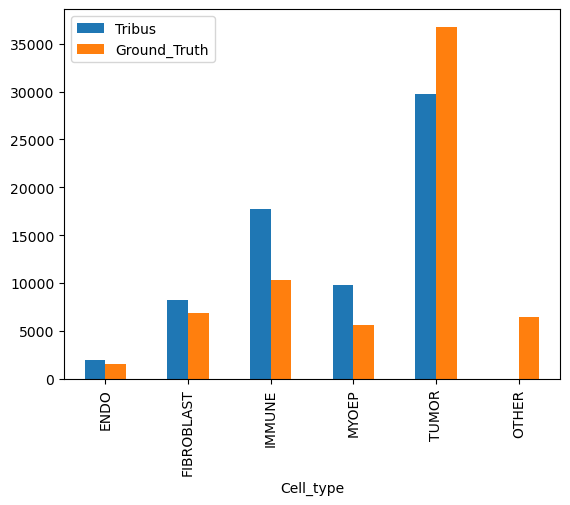

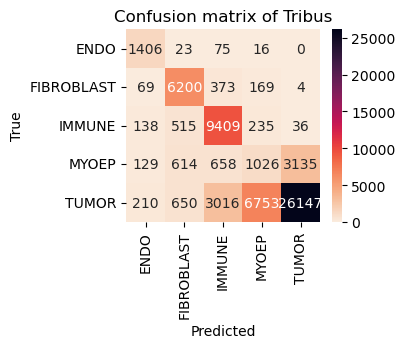

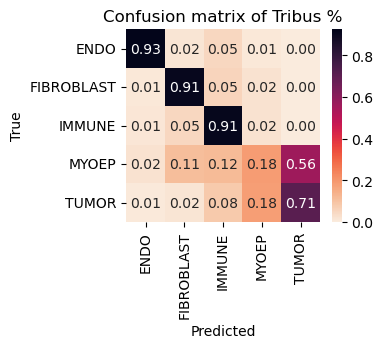

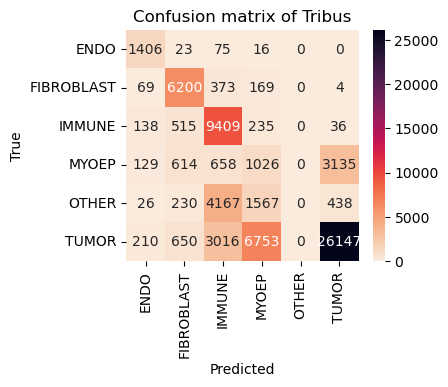

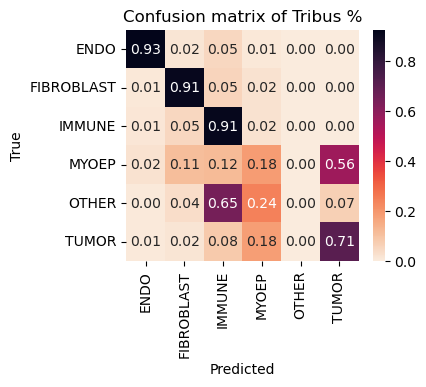

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.7479710407660983, Accuracy score = 0.6552777530622534, Precision score = 0.661420593743168, F1 score = 0.6439421313501268


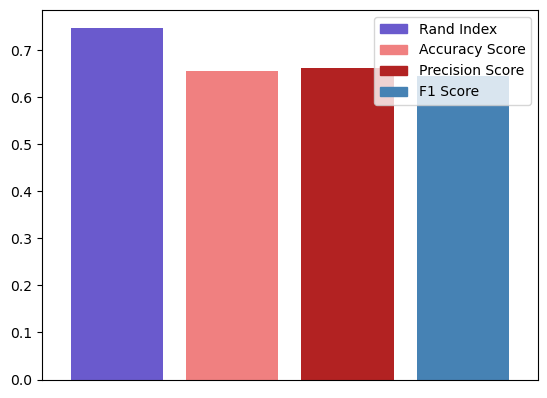

In [40]:
cell_num_compare(labels_true_2, labels_df["Global"])
my_confusion_matrix(labels_true_2, labels_df["Global"])
my_confusion_matrix_full(labels_true_2, labels_df["Global"])
cluster_metrics_overall(labels_true_2, labels_df["Global"])